In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *
from stattools.resampling import PermutationTest
from matplotlib_venn import venn2

In [2]:
chm13 = pd.read_csv('/Users/luciabazan/Downloads/chm13_gene_regions.csv', index_col=0)
chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13 = chm13.drop(columns=['START_GENE', 'END_GENE'])
chm13 = chm13.drop_duplicates()
chm13#['TYPE'].value_counts()

,SAMPLE,CHR,START,END,SCORE,TYPE,LENGHT
0,LP6005441-DNA_B02,chrX,105118,116978,1,DELETION,11860
18,LP6005441-DNA_B02,chrX,1038532,1048096,1,DELETION,9564
21,LP6005441-DNA_B02,chrX,1193541,1202443,1,DELETION,8902
24,LP6005441-DNA_B02,chrX,1296349,1304923,1,DELETION,8574
26,LP6005441-DNA_B02,chrX,1855267,1863572,1,DELETION,8305
...,...,...,...,...,...,...,...
1874421,LP6005442-DNA_H01,chr1,247606647,247620901,5,DUPLICATION,14254
1874427,LP6005442-DNA_H01,chr1,247629795,247637933,4,DUPLICATION,8138
1874430,LP6005442-DNA_H01,chr1,247738073,247750886,6,DUPLICATION,12813
1874432,LP6005442-DNA_H01,chr1,247954331,247967419,4,DUPLICATION,13088


In [5]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['SAMPLE'] = anotation['3-Illumina_ID']
ids_hg19['REGION'] = anotation['10-Region']
ids_hg19['COUNTRY'] = anotation['11-Country']

In [3]:
#change to df when using telomeres and centromeres filtration
cnv = chm13.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


cnv

SAMPLE,CHR,START,END,LP6005441-DNA_A01,LP6005441-DNA_A03,LP6005441-DNA_A04,LP6005441-DNA_A05,LP6005441-DNA_A06,LP6005441-DNA_A08,LP6005441-DNA_A09,...,LP6005677-DNA_D03,LP6005677-DNA_E01,LP6005677-DNA_F01,LP6005677-DNA_G01,LP6007068-DNA_A01,LP6007069-DNA_A01,SS6004471,SS6004477,SS6004478,SS6004480
0,chr1,102061,111943,12.0,15.0,11.0,14.0,15.0,12.0,11.0,...,15.0,13.0,14.0,14.0,14.0,12.0,15.0,11.0,13.0,16.0
1,chr1,521722,540598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0
2,chr1,613436,625116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,839350,851555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
4,chr1,1041679,1050074,NaN,NaN,1.0,1.0,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10743,chrY,26436587,26458551,5.0,0.0,0.0,4.0,4.0,3.0,NaN,...,0.0,4.0,0.0,4.0,4.0,0.0,3.0,4.0,0.0,4.0
10744,chrY,26778516,26788355,4.0,0.0,0.0,3.0,3.0,4.0,NaN,...,0.0,3.0,0.0,4.0,4.0,0.0,3.0,3.0,0.0,4.0
10745,chrY,62325695,62345374,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10746,chrY,62345374,62363313,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
coordinates = cnv.iloc[:,0:2]
cnvs = cnv.iloc[:,3:284]
cnvs = cnvs.T
cnvs = cnvs.fillna(2)
cnvs

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
SAMPLE,,,,,,,,,,,,,,,,,,,,,
LP6005441-DNA_A01,12.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,3.0,4.0,4.0,4.0,3.0,5.0,4.0,2.0,2.0,2.0
LP6005441-DNA_A03,15.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
LP6005441-DNA_A04,11.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
LP6005441-DNA_A05,14.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,3.0,2.0,4.0,3.0,2.0,2.0,2.0
LP6005441-DNA_A06,15.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP6007069-DNA_A01,12.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0
SS6004471,15.0,1.0,2.0,2.0,1.0,3.0,1.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0
SS6004477,11.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,...,2.0,3.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,2.0


In [10]:
dt = ids_hg19.set_index('SAMPLE').merge(cnvs, left_index=True, right_index=True)
features = dt.loc[:,['REGION', 'COUNTRY']]
features = features.sort_index()
features 

,REGION,COUNTRY
SAMPLE,,
LP6005441-DNA_A01,WestEurasia,Russia(Caucasus)
LP6005441-DNA_A03,Oceania,PapuaNewGuinea
LP6005441-DNA_A04,America,Colombia
LP6005441-DNA_A05,WestEurasia,France
LP6005441-DNA_A06,WestEurasia,Italy(Bergamo)
...,...,...
LP6007069-DNA_A01,WestEurasia,Greece
SS6004471,Africa,Congo
SS6004477,Oceania,Australia


In [191]:
####### Groupby regions #######
dt_group = dt.groupby('REGION')

dt_groupped = []
regions = features['REGION'].unique()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['REGION'].unique()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])

In [192]:
## VST for pair-population

from vst_function import *
vst_dt = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))
for region in combination_regions:
        statistic = vst((dt_groupped[region[0]]), (dt_groupped[region[1]]))
        vst_dt.append(statistic)

vst_dt = pd.DataFrame(vst_dt).set_axis(combination_names)
#vst_dt = vst_dt.T
vst_dt

/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/vst_function.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).var()
/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ret

/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/vst_function.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vt = pd.concat([x,y]).var()
/Users/luciabazan/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3721: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ret

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
WestEurasia-SouthAsia,0.018341,0.051059,NaN,0.011431,0.032919,0.211830,0.018174,0.026963,0.013699,NaN,...,0.011049,0.014368,0.010634,0.010957,0.013532,0.015718,0.016524,0.013699,0.013699,0.017159
WestEurasia-Africa,0.030527,0.011290,NaN,0.034343,0.011314,0.010878,0.015387,0.015938,0.013699,NaN,...,0.019031,0.037490,0.029717,0.025666,0.033569,0.032367,0.053015,0.013699,0.013699,0.016709
WestEurasia-CentralAsiaSiberia,0.106892,0.026284,NaN,0.035764,0.009836,0.008914,0.012906,0.012066,0.013699,0.040287,...,0.016610,0.012335,0.016269,0.014630,0.009739,0.009910,0.013250,0.013699,0.013699,0.018713
WestEurasia-Oceania,0.053486,0.008431,0.021739,0.010159,0.016229,0.013078,0.008636,0.008846,0.013699,0.021739,...,0.017906,0.017626,0.021756,0.020667,0.032477,0.022732,0.020829,0.009323,0.009323,0.008710
WestEurasia-America,0.139888,0.009650,NaN,0.016641,0.031034,0.011604,0.036289,0.009065,0.045439,0.026316,...,0.045856,0.034583,0.034854,0.034127,0.034310,0.027913,0.044059,0.013699,0.011016,0.009019
WestEurasia-EastAsia,0.045162,0.026437,NaN,0.024486,0.026242,0.011974,0.028864,0.011155,0.013699,NaN,...,0.068812,0.052202,0.085663,0.088231,0.070584,0.055544,0.052083,0.061000,0.061000,0.017473
SouthAsia-Africa,0.027853,0.058375,NaN,0.078571,0.068333,0.258437,0.059375,0.083034,NaN,NaN,...,0.028203,0.038188,0.041869,0.034977,0.036940,0.032124,0.048885,NaN,NaN,NaN
SouthAsia-CentralAsiaSiberia,0.177461,0.022490,NaN,0.053179,0.035647,0.291658,0.016585,0.025474,NaN,0.033682,...,0.028906,0.032129,0.026887,0.026288,0.024735,0.029184,0.038507,NaN,NaN,NaN
SouthAsia-Oceania,0.027726,0.063124,0.021739,NaN,0.022091,0.229167,0.028340,0.041079,NaN,0.021739,...,0.018641,0.014933,0.023273,0.020600,0.023021,0.015739,0.014851,0.021739,0.021739,0.021739
SouthAsia-America,0.105252,0.076120,NaN,0.036842,0.112390,0.208019,0.021033,0.037718,0.036842,0.026316,...,0.068615,0.073444,0.052900,0.052606,0.071957,0.072104,0.095339,NaN,0.026316,0.026316


In [193]:
filtering_vst = pd.DataFrame(vst_dt)>=0.2
filtering_vst = filtering_vst.loc[:, filtering_vst.any()]
#filtering_vst = filtering_vst.set_axis(combination_names)
filtering_vst

,0,5,30,35,52,62,63,76,81,101,...,10722,10723,10733,10734,10735,10736,10737,10738,10740,10741
WestEurasia-SouthAsia,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-Africa,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-CentralAsiaSiberia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-Oceania,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-America,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-EastAsia,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
SouthAsia-Africa,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SouthAsia-CentralAsiaSiberia,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SouthAsia-Oceania,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SouthAsia-America,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [194]:
## Coordinates anotation 
vst_dt = vst_dt.T
vst_dt.insert (0, 'CHR', cnv['CHR'])
vst_dt.insert (1, 'START', cnv['START'])
vst_dt.insert (2, 'END', cnv['END'])
vst_dt = vst_dt.round(5)
vst_dt = vst_dt.replace(np.NaN, 0)
vst_dt

,CHR,START,END,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
0,chr1,102061,111943,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,0.02785,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
1,chr1,521722,540598,0.05106,0.01129,0.02628,0.00843,0.00965,0.02644,0.05837,...,0.02602,0.01610,0.02000,0.03295,0.03112,0.03811,0.01472,0.01236,0.03382,0.04249
2,chr1,613436,625116,0.00000,0.00000,0.00000,0.02174,0.00000,0.00000,0.00000,...,0.00000,0.02174,0.00000,0.00000,0.02174,0.00000,0.00000,0.02174,0.02174,0.00000
3,chr1,839350,851555,0.01143,0.03434,0.03576,0.01016,0.01664,0.02449,0.07857,...,0.01641,0.08594,0.02500,0.02334,0.06494,0.01975,0.01632,0.04108,0.06103,0.01729
4,chr1,1041679,1050074,0.03292,0.01131,0.00984,0.01623,0.03103,0.02624,0.06833,...,0.01992,0.02805,0.03106,0.03323,0.01485,0.04769,0.04425,0.07140,0.06552,0.01557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10743,chrY,26436587,26458551,0.01572,0.03237,0.00991,0.02273,0.02791,0.05554,0.03212,...,0.05240,0.01880,0.10031,0.02318,0.03634,0.02508,0.08474,0.08454,0.02798,0.15662
10744,chrY,26778516,26788355,0.01652,0.05302,0.01325,0.02083,0.04406,0.05208,0.04888,...,0.09490,0.03142,0.17249,0.02172,0.04330,0.02843,0.09200,0.10247,0.02697,0.17179
10745,chrY,62325695,62345374,0.01370,0.01370,0.01370,0.00932,0.01370,0.06100,0.00000,...,0.00000,0.02174,0.00000,0.05015,0.02174,0.00000,0.05539,0.02174,0.06351,0.05485
10746,chrY,62345374,62363313,0.01370,0.01370,0.01370,0.00932,0.01102,0.06100,0.00000,...,0.00000,0.02174,0.02632,0.05015,0.02174,0.02632,0.05539,0.01213,0.06351,0.06481


In [195]:
permutation_results = pd.read_csv("permutation_chm13_gene_regions.csv",index_col='Unnamed: 0')
permutation_results

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
WestEurasia-Oceania,0.3840,0.0279,0.0001,0.8115,0.1204,0.0001,0.3745,0.2753,0.4222,0.0001,...,0.8145,0.5491,0.8103,0.7906,0.5871,0.4536,0.4263,1.0000,1.0000,0.6436
WestEurasia-America,0.1845,0.9120,0.0001,0.1484,0.9661,0.9757,0.4265,0.7279,0.7444,0.0001,...,0.3584,0.1233,0.1763,0.2581,0.1578,0.1705,0.0513,1.0000,1.0000,0.5786
WestEurasia-Africa,0.0007,0.1352,0.0001,0.0514,0.7887,0.9987,0.5831,0.4897,0.4367,0.0786,...,0.3539,0.5419,0.3723,0.4497,0.7692,0.7413,0.5087,0.9230,0.9209,0.5280
WestEurasia-EastAsia,0.0169,0.9990,0.2759,0.6083,0.2883,0.4744,0.8517,0.9996,0.8045,0.2699,...,0.2847,0.2829,0.2077,0.2474,0.0819,0.1948,0.2384,0.9260,0.9258,0.6249
WestEurasia-SouthAsia,0.0001,0.7527,0.0001,0.4777,0.1397,0.7622,0.1071,0.9794,0.0172,0.3394,...,0.0467,0.0987,0.0943,0.1019,0.1050,0.1400,0.0500,0.8571,0.8457,0.9719
WestEurasia-CentralAsiaSiberia,0.0582,0.2095,0.0001,0.2688,0.2273,0.7269,0.1603,0.6652,0.7588,0.0001,...,0.0148,0.0415,0.0056,0.0055,0.0151,0.0344,0.0388,0.0564,0.0538,0.5854
Oceania-America,0.6573,0.3178,0.0001,0.1500,0.2640,0.0017,0.2678,0.0959,0.0001,0.0001,...,0.5939,0.4541,0.3814,0.4761,0.4659,0.5291,0.2884,0.0001,0.0001,0.0001
Oceania-Africa,0.0007,0.5889,0.0001,0.2310,0.3319,0.0001,0.9851,0.5143,0.0001,0.5335,...,0.3790,0.3382,0.4101,0.4290,0.4462,0.3307,0.2208,0.0001,0.0001,0.0001
Oceania-EastAsia,0.3616,0.0705,0.7960,0.0001,0.5062,0.0004,0.3510,0.2455,0.0001,0.7957,...,0.5612,0.8578,0.4687,0.5450,0.4677,0.7393,0.8815,0.5753,0.5712,0.5685
Oceania-SouthAsia,0.0191,0.0703,0.0001,0.4007,0.0226,0.0008,0.7507,0.2842,0.3940,1.0000,...,0.0742,0.0519,0.1307,0.1366,0.0743,0.0641,0.0299,0.0001,1.0000,1.0000


In [196]:
boolean = (permutation_results<=0.05)


## Deleting columns where none of the regions passed the imputation
boolean = boolean.loc[:, boolean.any()]
boolean 


,0,1,2,3,4,5,8,9,11,12,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
WestEurasia-Oceania,False,True,True,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-America,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-Africa,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-EastAsia,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-SouthAsia,True,False,True,False,False,False,True,False,True,False,...,True,False,False,False,False,False,True,False,False,False
WestEurasia-CentralAsiaSiberia,False,False,True,False,False,False,False,True,False,False,...,True,True,True,True,True,True,True,False,False,False
Oceania-America,False,False,True,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,True,True,True
Oceania-Africa,True,False,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,True,True,True
Oceania-EastAsia,False,False,False,True,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-SouthAsia,True,False,True,False,True,True,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False


In [197]:
boolean.columns = boolean.columns.astype(int)
boolean.columns

Int64Index([    0,     1,     2,     3,     4,     5,     8,     9,    11,
               12,
            ...
            10738, 10739, 10740, 10741, 10742, 10743, 10744, 10745, 10746,
            10747],
           dtype='int64', length=9804)

In [198]:
# VST with permutation RESULTS 
pd.concat([filtering_vst.T, boolean.T],join='inner', axis=1)

,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,SouthAsia-CentralAsiaSiberia,SouthAsia-Oceania,SouthAsia-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,True,True,False,False,False
5,True,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
30,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,True,False,True,True
35,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,True
52,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
10737,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
10738,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
10740,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True


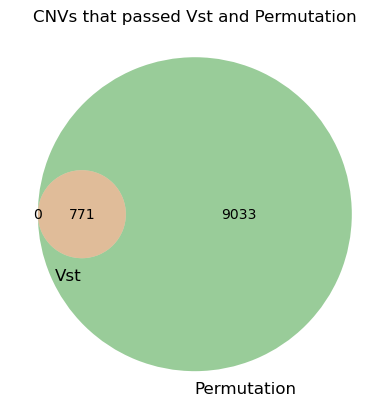

In [199]:
# VST with permutation RESULTS 
inner_vst = len(pd.concat([filtering_vst.T, boolean.T],join='inner', axis=1))
left_vst = len(filtering_vst.T) - inner_vst
right_vst = len(boolean.T) -inner_vst


venn2(subsets = (left_vst, right_vst, inner_vst), set_labels = ('Vst', 'Permutation'))
plt.title('CNVs that passed Vst and Permutation')
plt.show()

In [200]:
cnv_passed_vst = vst_dt.iloc[filtering_vst.columns]
cnv_passed_vst

,CHR,START,END,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
0,chr1,102061,111943,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,0.02785,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
5,chr1,1116984,1126261,0.21183,0.01088,0.00891,0.01308,0.01160,0.01197,0.25844,...,0.01640,0.01921,0.01913,0.02360,0.01708,0.01531,0.01743,0.01206,0.01420,0.01544
30,chr1,9337554,9350106,0.02579,0.14029,0.00912,0.02263,0.03687,0.17267,0.08796,...,0.17695,0.08299,0.06437,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
35,chr1,9852641,9861819,0.01044,0.01567,0.05117,0.00841,0.01500,0.13504,0.02827,...,0.08528,0.02112,0.04083,0.21588,0.05627,0.02953,0.04461,0.01869,0.15482,0.10585
52,chr1,12549468,12564684,0.01143,0.14668,0.09757,0.01238,0.02034,0.04428,0.28729,...,0.04949,0.09442,0.16881,0.08743,0.05031,0.12673,0.02490,0.03249,0.02484,0.07591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,chrY,24211645,24229764,0.01254,0.02530,0.01480,0.01700,0.03887,0.08079,0.03085,...,0.05317,0.01784,0.09779,0.03571,0.04023,0.02219,0.14081,0.08546,0.05250,0.23520
10737,chrY,24229764,24251349,0.01033,0.02374,0.01560,0.02033,0.03418,0.08528,0.03806,...,0.05531,0.01609,0.08758,0.04065,0.05004,0.01996,0.16229,0.08625,0.05038,0.22429
10738,chrY,24251349,24283859,0.01105,0.01903,0.01661,0.01791,0.04586,0.06881,0.02820,...,0.04302,0.01563,0.08019,0.03485,0.04630,0.02375,0.12686,0.10006,0.04442,0.21254
10740,chrY,25831552,25849672,0.01063,0.02972,0.01627,0.02176,0.03485,0.08566,0.04187,...,0.06571,0.01820,0.10471,0.03462,0.05435,0.01873,0.15970,0.09586,0.05306,0.23563


<h1> Introducing cnvs from old assembly 

In [201]:
cnv_vst_hg19 = pd.read_csv("../data/candidates_574.csv", index_col='Unnamed: 0')
cnv_vst_hg19['start'] = cnv_vst_hg19['start'] +1
cnv_vst_hg19['start'] = cnv_vst_hg19['start'].apply(lambda x: str(x))
cnv_vst_hg19['end'] = cnv_vst_hg19['end'].apply(lambda x: str(x))
cnv_vst_hg19

,chr,start,end,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
36,1,8359740,8364181,NaN,NaN,0.24315,NaN,0.39153,NaN,NaN,...,0.21795,NaN,0.36120,NaN,NaN,NaN,0.22035,0.31300,NaN,0.36420
37,1,9845437,9863387,NaN,NaN,NaN,NaN,0.26365,NaN,NaN,...,NaN,NaN,0.32252,NaN,NaN,NaN,NaN,0.21695,NaN,NaN
49,1,13725297,13733660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.23619,0.23093,NaN,0.35185,0.34632,NaN,NaN,NaN,NaN
51,1,14436061,14439381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22469
55,1,16148565,16154830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.23843,NaN,NaN,0.40450,NaN,NaN,NaN,0.31536,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8586,X,146037798,146042345,NaN,0.22866,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8588,X,146360193,146369374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34919,NaN,NaN
8646,X,154788812,154840186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.30299,NaN,NaN,0.24022,0.25329,NaN
8647,X,154789311,154826421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.30299,NaN,NaN,0.24022,0.25329,NaN


In [202]:
lifover_hg19_chm13 = pd.read_csv("../data/hglft_genome_33223_b1ed30.bed", sep='\t', names=['CHR','START','END','OLD','i']) 
#lifover_hg19_chm13['START'] = lifover_hg19_chm13['START'].apply(lambda x: str(x))
#lifover_hg19_chm13['END'] = lifover_hg19_chm13['END'].apply(lambda x: str(x))
lifover_hg19_chm13[['chr', 'position']] = lifover_hg19_chm13.OLD.str.split(":", expand = True)
lifover_hg19_chm13['chr_num'] = lifover_hg19_chm13['chr'].map(lambda x: x.lstrip('chr').rstrip('aAbBcC'))
lifover_hg19_chm13[['start', 'end']] = lifover_hg19_chm13.position.str.split("-", expand = True)
lifover_hg19_chm13

,CHR,START,END,OLD,i,chr,position,chr_num,start,end
0,chr1,7831416,7835810,chr1:8359740-8364181,1,chr1,8359740-8364181,1,8359740,8364181
1,chr1,9328164,9346113,chr1:9845437-9863387,1,chr1,9845437-9863387,1,9845437,9863387
2,chr1,12840112,12848473,chr1:13725297-13733660,1,chr1,13725297-13733660,1,13725297,13733660
3,chr1,13551736,13555057,chr1:14436061-14439381,1,chr1,14436061-14439381,1,14436061,14439381
4,chr1,15266831,15270191,chr1:16148565-16154830,1,chr1,16148565-16154830,1,16148565,16154830
...,...,...,...,...,...,...,...,...,...,...
695,chrX,153797464,153835748,chrX:154788812-154840186,1,chrX,154788812-154840186,X,154788812,154840186
696,chrX,153847068,153847378,chrX:154788812-154840186,2,chrX,154788812-154840186,X,154788812,154840186
697,chrX,153797963,153821992,chrX:154789311-154826421,1,chrX,154789311-154826421,X,154789311,154826421
698,chrX,153847068,153847378,chrX:154789311-154826421,2,chrX,154789311-154826421,X,154789311,154826421


In [203]:
#cnv_vst_hg19.merge(lifover_hg19_chm13, how='inner', on=['chr,start,end'])
#cnv_passed_vst

cnvs_hg19_overlift = pd.merge(cnv_vst_hg19, lifover_hg19_chm13,  how='inner', left_on=['chr','start','end'], right_on = ['chr_num','start','end'])
cnvs_hg19_overlift

,chr_x,start,end,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Oceania-EastAsia,America-EastAsia,CHR,START,END,OLD,i,chr_y,position,chr_num
0,1,8359740,8364181,NaN,NaN,0.24315,NaN,0.39153,NaN,NaN,...,NaN,0.36420,chr1,7831416,7835810,chr1:8359740-8364181,1,chr1,8359740-8364181,1
1,1,9845437,9863387,NaN,NaN,NaN,NaN,0.26365,NaN,NaN,...,NaN,NaN,chr1,9328164,9346113,chr1:9845437-9863387,1,chr1,9845437-9863387,1
2,1,13725297,13733660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,chr1,12840112,12848473,chr1:13725297-13733660,1,chr1,13725297-13733660,1
3,1,14436061,14439381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.22469,chr1,13551736,13555057,chr1:14436061-14439381,1,chr1,14436061-14439381,1
4,1,16148565,16154830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.31536,NaN,chr1,15266831,15270191,chr1:16148565-16154830,1,chr1,16148565-16154830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,X,154788812,154840186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153797464,153835748,chrX:154788812-154840186,1,chrX,154788812-154840186,X
696,X,154788812,154840186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153847068,153847378,chrX:154788812-154840186,2,chrX,154788812-154840186,X
697,X,154789311,154826421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153797963,153821992,chrX:154789311-154826421,1,chrX,154789311-154826421,X
698,X,154789311,154826421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25329,NaN,chrX,153847068,153847378,chrX:154789311-154826421,2,chrX,154789311-154826421,X


<h1> gene anotation

In [235]:
feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')
report = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
gene_anotation = pd.DataFrame()
gene_anotation['CHR_2'] = chm13_gene_anotation['GenBank-Accn']
gene_anotation['START'] = chm13_gene_anotation['start']
gene_anotation['END'] = chm13_gene_anotation['end']
gene_anotation['CHR'] = chm13_gene_anotation['chromosome'] 
gene_anotation['SYMBOL'] = chm13_gene_anotation['symbol'] 
gene_anotation['GENEID'] = chm13_gene_anotation['GeneID'] 
gene_anotation['CHR'] = gene_anotation['CHR'].apply(lambda x: "chr" + str(x))
gene_anotation

/var/folders/05/q9klbb6d06d76xy7b8th0xf40000gn/T/ipykernel_10620/2980563526.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')


,CHR_2,START,END,CHR,SYMBOL,GENEID
0,CP068277.2,11134,37628,chr1,LOC105378947,105378947
1,CP068277.2,11134,37628,chr1,LOC105378947,105378947
2,CP068277.2,13463,37628,chr1,LOC105378947,105378947
3,CP068277.2,20892,23710,chr1,LOC124905685,124905685
4,CP068277.2,20892,23710,chr1,LOC124905685,124905685
...,...,...,...,...,...,...
236307,CP086569.2,62446549,62449392,chrY,LOC124908905,124908905
236308,CP086569.2,62446549,62449392,chrY,LOC124908905,124908905
236309,CP086569.2,62446549,62449100,chrY,LOC124908905,124908905
236310,CP086569.2,62449384,62451910,chrY,DDX11L16,727856


In [238]:
overlapped = []

cnvs_hg19_overlift_np = gene_anotation.to_numpy()
cnv_passed_vst_np = cnv_passed_vst.to_numpy()

for cnv_q in cnvs_hg19_overlift_np:
    for cnv_c in cnv_passed_vst_np:
    
        if cnv_q[3] == cnv_c[0]: #Chromosome
            # QDNASEQ CNVS in SUDMANT DATA(SUDMANT bigger than  QDNASEQ)
            if (cnv_c[1] <= cnv_q[1] <= cnv_c[2]) or (cnv_c[1] <= cnv_q[2] <= cnv_c[2]):
                #leng_dqna = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_dqna/leng_cnvnator)>0.6:
                overlapped.append([cnv_c[0], cnv_c[1], cnv_c[2], cnv_q[4]])
                    #overlapped.append(cnv_q)
            # SUDMANT DATA CNVS in QDNASEQ CNVs(QDNASEQ bigger than SUDMANT DATA)
            
            if (cnv_q[1] <= cnv_c[1] <= cnv_q[2]) or (cnv_q[1] <= cnv_c[2] <= cnv_q[2]):
                #leng_dq/na = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_cnvnator/leng_dqna)>0.6:
                overlapped.append([cnv_c[0], cnv_c[1], cnv_c[2], cnv_q[4]])
                    #overlapped.append([cnv_q, cnv_c])
                    #overlapped.append(cnv_q)

In [242]:
genes = pd.DataFrame(overlapped).drop_duplicates()
genes.columns = ['CHR', 'START', 'END', 'SYMBOL']
genes

,CHR,START,END,SYMBOL
0,chr1,102061,111943,OR4F29
6,chr1,1116984,1126261,SLC35E2B
9,chr1,9337554,9350106,CLSTN1
16,chr1,9852641,9861819,KIF1B
23,chr1,12549468,12564684,PRAMEF13
...,...,...,...,...
7029,chrY,24211645,24229764,BPY2B
7031,chrY,24229764,24251349,BPY2B
7038,chrY,24251349,24283859,TTTY4B
7042,chrY,25831552,25849672,BPY2


In [245]:
cnv_passed_vst = genes.merge(cnv_passed_vst)
cnv_passed_vst

,CHR,START,END,SYMBOL,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
0,chr1,102061,111943,OR4F29,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
1,chr1,1116984,1126261,SLC35E2B,0.21183,0.01088,0.00891,0.01308,0.01160,0.01197,...,0.01640,0.01921,0.01913,0.02360,0.01708,0.01531,0.01743,0.01206,0.01420,0.01544
2,chr1,9337554,9350106,CLSTN1,0.02579,0.14029,0.00912,0.02263,0.03687,0.17267,...,0.17695,0.08299,0.06437,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
3,chr1,9852641,9861819,KIF1B,0.01044,0.01567,0.05117,0.00841,0.01500,0.13504,...,0.08528,0.02112,0.04083,0.21588,0.05627,0.02953,0.04461,0.01869,0.15482,0.10585
4,chr1,12549468,12564684,PRAMEF13,0.01143,0.14668,0.09757,0.01238,0.02034,0.04428,...,0.04949,0.09442,0.16881,0.08743,0.05031,0.12673,0.02490,0.03249,0.02484,0.07591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,chrY,24211645,24229764,BPY2B,0.01254,0.02530,0.01480,0.01700,0.03887,0.08079,...,0.05317,0.01784,0.09779,0.03571,0.04023,0.02219,0.14081,0.08546,0.05250,0.23520
860,chrY,24229764,24251349,BPY2B,0.01033,0.02374,0.01560,0.02033,0.03418,0.08528,...,0.05531,0.01609,0.08758,0.04065,0.05004,0.01996,0.16229,0.08625,0.05038,0.22429
861,chrY,24251349,24283859,TTTY4B,0.01105,0.01903,0.01661,0.01791,0.04586,0.06881,...,0.04302,0.01563,0.08019,0.03485,0.04630,0.02375,0.12686,0.10006,0.04442,0.21254
862,chrY,25831552,25849672,BPY2,0.01063,0.02972,0.01627,0.02176,0.03485,0.08566,...,0.06571,0.01820,0.10471,0.03462,0.05435,0.01873,0.15970,0.09586,0.05306,0.23563


<h1> overlapped with hg19

In [246]:
overlapped = []

cnvs_hg19_overlift_np = cnvs_hg19_overlift.to_numpy()
cnv_passed_vst_np = cnv_passed_vst.to_numpy()

for cnv_q in cnvs_hg19_overlift_np:
    for cnv_c in cnv_passed_vst_np:
    
        if cnv_q[-3] == cnv_c[0]: #Chromosome
            # QDNASEQ CNVS in SUDMANT DATA(SUDMANT bigger than  QDNASEQ)
            if (cnv_c[1] <= cnv_q[-7] <= cnv_c[2]) or (cnv_c[1] <= cnv_q[-6] <= cnv_c[2]):
                #leng_dqna = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_dqna/leng_cnvnator)>0.6:
                overlapped.append([cnv_q[-8], cnv_q[-7], cnv_q[-6], cnv_c[0], cnv_c[1], cnv_c[2]])
                    #overlapped.append(cnv_q)
            # SUDMANT DATA CNVS in QDNASEQ CNVs(QDNASEQ bigger than SUDMANT DATA)
            
            if (cnv_q[-7] <= cnv_c[1] <= cnv_q[-6]) or (cnv_q[-7] <= cnv_c[2] <= cnv_q[-6]):
                #leng_dq/na = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_cnvnator/leng_dqna)>0.6:
                overlapped.append([cnv_q[-8], cnv_q[-7], cnv_q[-6], cnv_c[0], cnv_c[1], cnv_c[2]])
                    #overlapped.append([cnv_q, cnv_c])
                    #overlapped.append(cnv_q)

In [247]:
overlapped_cnvs = pd.DataFrame(overlapped)
overlapped_cnvs = overlapped_cnvs.drop_duplicates()

In [248]:
overlapped_cnvs.columns = ['chr', 'start', 'end', 'CHR','START', 'END']
overlapped_cnvs['lenght'] = overlapped_cnvs['end'] - overlapped_cnvs['start']
overlapped_cnvs['LENGHT'] = overlapped_cnvs['END'] - overlapped_cnvs['START']
overlapped_cnvs

,chr,start,end,CHR,START,END,lenght,LENGHT
0,chr1,9328164,9346113,chr1,9337554,9350106,17949,12552
2,chr1,144416713,144500870,chr1,144416000,144502839,84157,86839
3,chr1,147813464,147869168,chr1,147813843,147824531,55704,10688
4,chr1,144467509,144468142,chr1,144416000,144502839,633,86839
5,chr1,168602793,168640912,chr1,168602705,168615424,38119,12719
7,chr1,168602793,168640912,chr1,168616996,168625289,38119,8293
8,chr11,47189450,47199853,chr11,47189271,47198341,10403,9070
12,chr11,47189450,47199853,chr11,47198341,47207572,10403,9231
16,chr12,8170591,8419854,chr12,8170744,8180936,249263,10192
17,chr14,67731462,67794751,chr14,67767430,67776722,63289,9292


In [249]:
cnvs_chm13and_hg19 = overlapped_cnvs.merge(cnv_passed_vst, how='left', on=['CHR', 'START','END'])

In [250]:
cnvs_chm13and_hg19.sort_values(by='Africa-America')

,chr,start,end,CHR,START,END,lenght,LENGHT,SYMBOL,WestEurasia-SouthAsia,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
27,chr8,23424581,23439842,chr8,23424961,23435696,15261,10735,TNFRSF10D,0.34639,...,0.07859,0.02174,0.00000,0.00000,0.07698,0.10163,0.08916,0.02174,0.02174,0.00000
23,chr4,71940842,72129162,chr4,72079101,72088338,188320,9237,UGT2B15,0.02006,...,0.09213,0.05391,0.01725,0.06041,0.22139,0.08664,0.20341,0.05162,0.01374,0.04912
28,chr9,48034272,48144584,chr9,48124047,48142608,110312,18561,LOC105379444,0.03200,...,0.01921,0.02492,0.01803,0.08069,0.01662,0.01348,0.09329,0.02059,0.08432,0.08736
11,chr14,67731462,67794751,chr14,67767430,67776722,63289,9292,ACOT2,0.05750,...,0.01662,0.15325,0.01862,0.29078,0.17409,0.01578,0.28041,0.16775,0.05648,0.30533
6,chr11,47189450,47199853,chr11,47189271,47198341,10403,9070,CSTPP1,0.02399,...,0.29567,0.02154,0.01971,0.13040,0.18997,0.31585,0.62081,0.03103,0.16441,0.08879
7,chr11,47189450,47199853,chr11,47189271,47198341,10403,9070,LOC112268075,0.02399,...,0.29567,0.02154,0.01971,0.13040,0.18997,0.31585,0.62081,0.03103,0.16441,0.08879
10,chr12,8170591,8419854,chr12,8170744,8180936,249263,10192,ZNF705A,0.01615,...,0.09062,0.05720,0.02009,0.19061,0.20170,0.11618,0.27440,0.03055,0.05792,0.10843
19,chr3,46769482,46825196,chr3,46772136,46814357,55714,42221,PRSS43P,0.04890,...,0.25864,0.05000,0.02098,0.05000,0.39488,0.34678,0.33236,0.02632,0.00000,0.02632
25,chr6,66152806,66165839,chr6,66158071,66166219,13033,8148,EYS,0.07729,...,0.12069,0.01583,0.02933,0.06049,0.07676,0.05471,0.03704,0.01869,0.03683,0.02266
24,chr5,179511134,179518155,chr5,179504008,179516826,7021,12818,ZNF454,0.07896,...,0.04121,0.13043,0.03571,0.14815,0.09522,0.01441,0.07983,0.11249,0.01598,0.10096


In [241]:
cnv_passed_vst

,CHR,START,END,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
0,chr1,102061,111943,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,0.02785,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
5,chr1,1116984,1126261,0.21183,0.01088,0.00891,0.01308,0.01160,0.01197,0.25844,...,0.01640,0.01921,0.01913,0.02360,0.01708,0.01531,0.01743,0.01206,0.01420,0.01544
30,chr1,9337554,9350106,0.02579,0.14029,0.00912,0.02263,0.03687,0.17267,0.08796,...,0.17695,0.08299,0.06437,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
35,chr1,9852641,9861819,0.01044,0.01567,0.05117,0.00841,0.01500,0.13504,0.02827,...,0.08528,0.02112,0.04083,0.21588,0.05627,0.02953,0.04461,0.01869,0.15482,0.10585
52,chr1,12549468,12564684,0.01143,0.14668,0.09757,0.01238,0.02034,0.04428,0.28729,...,0.04949,0.09442,0.16881,0.08743,0.05031,0.12673,0.02490,0.03249,0.02484,0.07591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,chrY,24211645,24229764,0.01254,0.02530,0.01480,0.01700,0.03887,0.08079,0.03085,...,0.05317,0.01784,0.09779,0.03571,0.04023,0.02219,0.14081,0.08546,0.05250,0.23520
10737,chrY,24229764,24251349,0.01033,0.02374,0.01560,0.02033,0.03418,0.08528,0.03806,...,0.05531,0.01609,0.08758,0.04065,0.05004,0.01996,0.16229,0.08625,0.05038,0.22429
10738,chrY,24251349,24283859,0.01105,0.01903,0.01661,0.01791,0.04586,0.06881,0.02820,...,0.04302,0.01563,0.08019,0.03485,0.04630,0.02375,0.12686,0.10006,0.04442,0.21254
10740,chrY,25831552,25849672,0.01063,0.02972,0.01627,0.02176,0.03485,0.08566,0.04187,...,0.06571,0.01820,0.10471,0.03462,0.05435,0.01873,0.15970,0.09586,0.05306,0.23563
